# Figure 5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

# 5a-b

In [9]:
c_type = pd.read_csv('cancer_type_counts_per_guide.csv')
total_counts = np.sum(c_type[c_type.columns[:-1]], axis=1)

count_muts = pd.DataFrame(dict(zip(['gRNA_id', 'mutation_count'], [c_type['gRNA_id'], total_counts])))

master = pd.read_csv('master_table_min50_control_mean_invitro.csv')
master_targ = master[(master['classification']=='targeting guide') & (master['legacy']==False)]

m1 = pd.merge(master_targ, count_muts, on='gRNA_id')
#exclude mutations with indexing issues
m1 = m1[m1['mutation_count']!=0]

In [10]:
cosmic = pd.read_csv('source_data/Census_allSun Nov 17 02_26_47 2024.csv').fillna('Undefined')

#MBES = pd.read_csv('MBESv2_CORRECTED.csv')

t_dict = {'TSG':'TSG', 'TSG, fusion':'TSG', 'Undefined':'Undefined', 'fusion':'Undefined', 'oncogene':'Oncogene',
       'oncogene, TSG':'Oncogene/TSG', 'oncogene, TSG, fusion':'Oncogene/TSG', 'oncogene, fusion': 'Oncogene'}

gene_type = []
for i, val in m1.iterrows():
    v = val['gene_name_h']
    subset = cosmic[cosmic['Gene Symbol']==v]
    if len(subset)==0:
        gene_type.append('Undefined')
    else:
        v2 = subset['Role in Cancer'].values[0]

        gene_type.append(t_dict[v2])

m1['Role in Cancer']=gene_type

In [11]:
u, c= np.unique(m1['gene_name_m'], return_counts=True)
dd = pd.DataFrame(dict(zip(['gene', 'count'], [u,c]))).sort_values(by='count', ascending=False)
top_genes = list(dd[dd['count']>=40]['gene'])

edit_cutoff = 20

corr_spleen = []
corr_iv = []
corr_bone = []
corr_men = []
num_gRNAs = []

for i in top_genes:

    
    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=edit_cutoff)] #.sort_values(by='LFC_Bone', ascending=False).reset_index(drop=True)
    x,y = m2['mutation_count'], m2['LFC_Bone']
    ff = scipy.stats.pearsonr(x,y).statistic
    corr_bone.append(ff)

    num_gRNAs.append(len(m2))

    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=edit_cutoff)] #.sort_values(by='LFC_Bone', ascending=False).reset_index(drop=True)
    x,y = m2['mutation_count'], m2['LFC_Spleen']
    ff = scipy.stats.pearsonr(x,y).statistic
    corr_spleen.append(ff)

    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=edit_cutoff)] #.sort_values(by='LFC_Bone', ascending=False).reset_index(drop=True)
    x,y = m2['mutation_count'], m2['LFC_In Vitro D15']
    ff = scipy.stats.pearsonr(x,y).statistic
    corr_iv.append(ff)

    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=edit_cutoff)] #.sort_values(by='LFC_Bone', ascending=False).reset_index(drop=True)
    x,y = m2['mutation_count'], m2['LFC_Meninges']
    ff = scipy.stats.pearsonr(x,y).statistic
    corr_men.append(ff)


corr_df = pd.DataFrame(dict(zip(['gene', 'num_gRNAs', 'corr_iv', 'corr_spleen', 'corr_bone', 'corr_men'], [top_genes, num_gRNAs, corr_iv, corr_spleen, corr_bone, corr_men])))

cos = m1[['gene_name_m', 'Role in Cancer',]].drop_duplicates().rename(columns = {'gene_name_m':'gene'})
corr_df2 = pd.merge(corr_df, cos, on='gene')

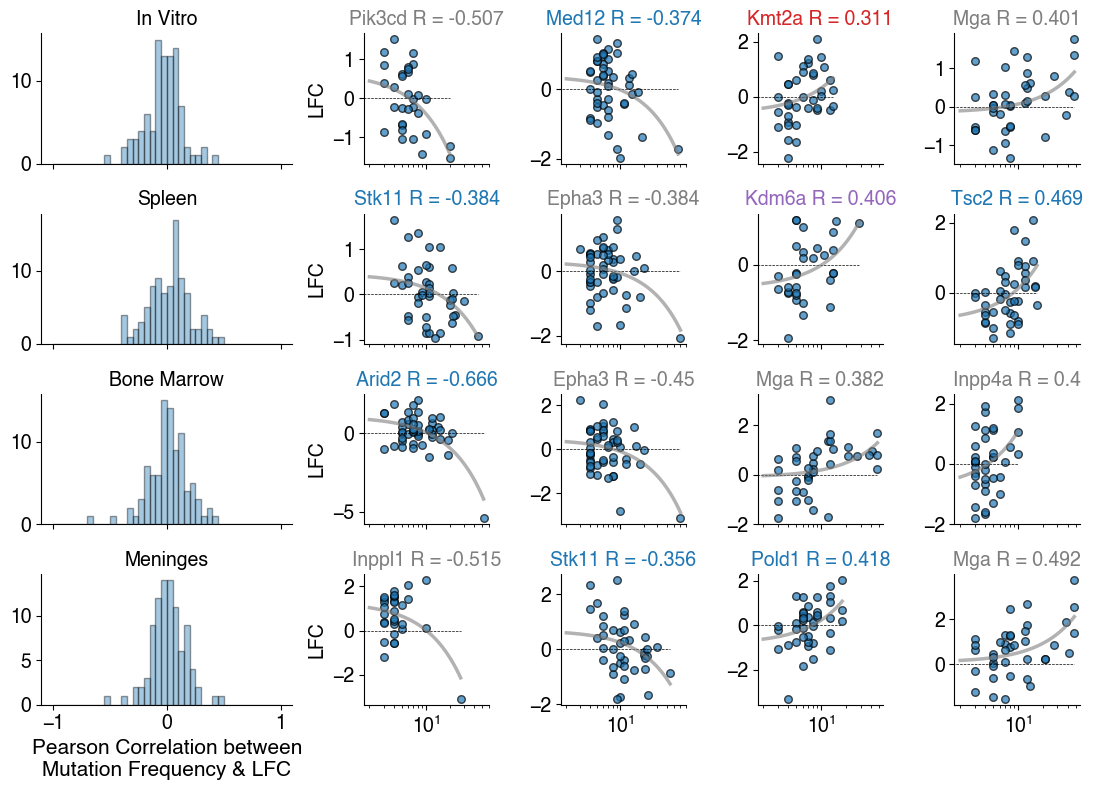

In [12]:
fig, ax= plt.subplots(4,5, figsize=(11,8), sharey=False, sharex='col', width_ratios=[1,.5, .5, .5, .5])


corr_df3 = corr_df2[corr_df2['num_gRNAs']>=30]

ax[0][0].hist(corr_df3['corr_iv'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[1][0].hist(corr_df3['corr_spleen'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[2][0].hist(corr_df3['corr_bone'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[3][0].hist(corr_df3['corr_men'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[0][0].set_title('In Vitro', fontsize=14)
ax[1][0].set_title('Spleen', fontsize=14)
ax[2][0].set_title('Bone Marrow', fontsize=14)
ax[3][0].set_title('Meninges', fontsize=14)


color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}

samps = ['corr_iv', 'corr_spleen', 'corr_bone', 'corr_men']

jj = ['LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']
for idx, j in enumerate(samps):
    k = corr_df3.sort_values(by=j, ascending=False).reset_index()
    top = list(k['gene'])[0]
    top2 = list(k['gene'])[1]
    bot = list(k['gene'])[-1]
    bot2 = list(k['gene'])[-2]

    t1 = corr_df3.loc[corr_df3['gene']==top, 'Role in Cancer'].values[0]
    t2 = corr_df3.loc[corr_df3['gene']==top2, 'Role in Cancer'].values[0]
    b1 = corr_df3.loc[corr_df3['gene']==bot, 'Role in Cancer'].values[0]
    b2 = corr_df3.loc[corr_df3['gene']==bot2, 'Role in Cancer'].values[0]

    t_color = color_dict[t1]
    t_color2 = color_dict[t2]
    b_color = color_dict[b1]
    b_color2 = color_dict[b2]

    tissue = jj[idx]

    m2 = m1[(m1['gene_name_m']==top) & (m1['target_base_edit_perc']>=edit_cutoff)]
    x,y = m2['mutation_count'], m2[tissue]
    rr = np.round(scipy.stats.pearsonr(x,y).statistic,3)
    ax[idx][4].scatter(x,y, alpha=.7, edgecolor='black', s=30)
    ax[idx][4].set_xscale('log')
    ax[idx][4].set_title(f'{top} R = {rr}', fontsize=14,c=t_color)
    ax[idx][4].plot([0,max(x)], [0,0], linewidth=.5, color='black', linestyle='dashed')


    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(2, max(x), num=100)
    # Plot regression line
    ax[idx][4].plot(xseq, a + b * xseq, color="tab:grey", lw=2.5, alpha=.6)



    m2 = m1[(m1['gene_name_m']==top2) & (m1['target_base_edit_perc']>=edit_cutoff)]
    x,y = m2['mutation_count'], m2[tissue]
    rr = np.round(scipy.stats.pearsonr(x,y).statistic,3)
    ax[idx][3].scatter(x,y, alpha=.7, edgecolor='black', s=30)
    ax[idx][3].set_xscale('log')
    ax[idx][3].set_title(f'{top2} R = {rr}', fontsize=14,c=t_color2)
    ax[idx][3].plot([0,max(x)], [0,0], linewidth=.5, color='black', linestyle='dashed')
    
    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(2, max(x), num=100)
    # Plot regression line
    ax[idx][3].plot(xseq, a + b * xseq, color="tab:grey", lw=2.5, alpha=.6)

    m2 = m1[(m1['gene_name_m']==bot2) & (m1['target_base_edit_perc']>=edit_cutoff)]
    x,y = m2['mutation_count'], m2[tissue]
    rr = np.round(scipy.stats.pearsonr(x,y).statistic,3)
    ax[idx][2].scatter(x,y, alpha=.7, edgecolor='black', s=30)
    ax[idx][2].set_xscale('log')
    ax[idx][2].set_title(f'{bot2} R = {rr}', fontsize=14, c=b_color2)
    ax[idx][2].plot([0,max(x)], [0,0], linewidth=.5, color='black', linestyle='dashed')


    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(2, max(x), num=100)
    # Plot regression line
    ax[idx][2].plot(xseq, a + b * xseq, color="tab:grey", lw=2.5, alpha=.6)


    m2 = m1[(m1['gene_name_m']==bot) & (m1['target_base_edit_perc']>=edit_cutoff)]
    x,y = m2['mutation_count'], m2[tissue]
    rr = np.round(scipy.stats.pearsonr(x,y).statistic,3)
    ax[idx][1].scatter(x,y, alpha=.7, edgecolor='black', s=30)
    ax[idx][1].set_xscale('log')
    ax[idx][1].set_title(f'{bot} R = {rr}', fontsize=14, c=b_color)
    ax[idx][1].plot([0,max(x)], [0,0], linewidth=.5, color='black', linestyle='dashed')


    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(2, max(x), num=100)
    # Plot regression line
    ax[idx][1].plot(xseq, a + b * xseq, color="tab:grey", lw=2.5, alpha=.6)


    ax[idx][1].set_ylabel('LFC', fontsize=14)
    #ax[idx][2].set_ylabel('LFC', fontsize=14)
    #ax[idx][3].set_ylabel('LFC', fontsize=14)
    #ax[idx][4].set_ylabel('LFC', fontsize=14)

    

for i in range(4):
    for k in range(5):
        ax[i][k].spines[['top', 'right']].set_visible(False)
        ax[i][k].tick_params(axis='both', which='major', labelsize=14)
        ax[i][k].patch.set_facecolor('None')


ax[3][0].set_xlabel('Pearson Correlation between\nMutation Frequency & LFC', fontsize=15)
fig.tight_layout()
#fig.savefig('figures/fig4_freqv2.pdf')

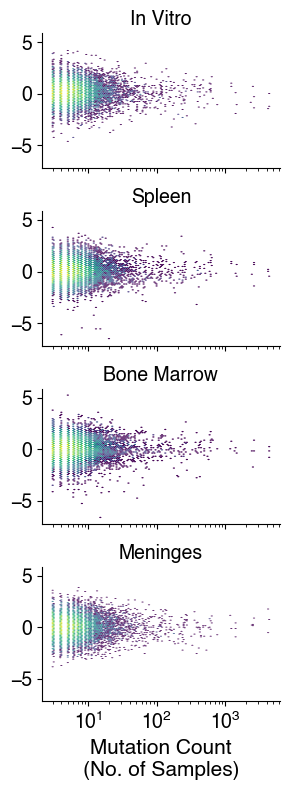

In [13]:
edit_cutoff = 20
m2 = m1[(m1['target_base_edit_perc']>=edit_cutoff)]

fig, ax= plt.subplots(4,1, figsize=(3,8), sharey=True, sharex=True)

corr_df3 = corr_df2[corr_df2['num_gRNAs']>=30]

#ax[0].set_xscale('log')

ax[0].hexbin(m2['mutation_count'], m2['Z_In Vitro D15'], bins='log', xscale='log', linewidths=0)
ax[1].hexbin(m2['mutation_count'], m2['Z_Spleen'], bins='log', xscale='log', linewidths=0)
ax[2].hexbin(m2['mutation_count'], m2['Z_Bone'], bins='log', xscale='log', linewidths=0)
ax[3].hexbin(m2['mutation_count'], m2['Z_Meninges'], bins='log', xscale='log', linewidths=0)


ax[0].set_title('In Vitro', fontsize=14)
ax[1].set_title('Spleen', fontsize=14)
ax[2].set_title('Bone Marrow', fontsize=14)
ax[3].set_title('Meninges', fontsize=14)

for i in range(4):
    ax[i].spines[['top', 'right']].set_visible(False)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].patch.set_facecolor('None')


ax[3].set_xlabel('Mutation Count\n(No. of Samples)', fontsize=15)
fig.tight_layout()

# Fig. 5c-d (KO vs. BE)

In [14]:
KO = pd.read_csv('KO_LFC.csv')

KO_spleen = KO[['sgrna', 'LFC_spleen']].rename(columns = {'sgrna':'gRNA_id', 'LFC_spleen':'LFC_KO'})


BE = pd.read_csv('master_table_min50_control_mean_invitro.csv')
BE = BE[(BE['classification']=='targeting guide') & (BE['Editor']=='ABE') & (BE['target_base_edit_perc']>=20)]

merged = pd.merge(KO_spleen, BE, on='gRNA_id')


cosmic = pd.read_csv('source_data/Census_allSun Nov 17 02_26_47 2024.csv').fillna('Undefined')

#MBES = pd.read_csv('MBESv2_CORRECTED.csv')

t_dict = {'TSG':'TSG', 'TSG, fusion':'TSG', 'Undefined':'Undefined', 'fusion':'Undefined', 'oncogene':'Oncogene',
       'oncogene, TSG':'Oncogene/TSG', 'oncogene, TSG, fusion':'Oncogene/TSG', 'oncogene, fusion': 'Oncogene'}

gene_type = []
for i, val in merged.iterrows():
    v = val['gene_name_h']
    subset = cosmic[cosmic['Gene Symbol']==v]
    if len(subset)==0:
        gene_type.append('Undefined')
    else:
        v2 = subset['Role in Cancer'].values[0]

        gene_type.append(t_dict[v2])

merged['Role in Cancer']=gene_type

In [17]:
x = merged['LFC_KO']
y = merged['LFC_Spleen']

delta = y-x

merged['delta'] = delta

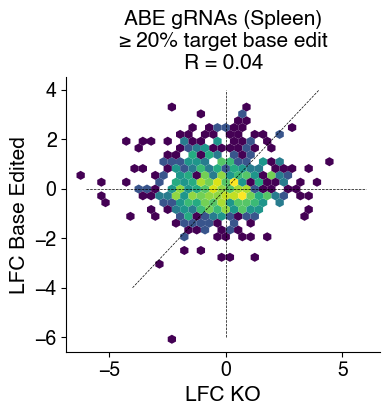

In [18]:
#plt.scatter(x,y)

x = merged['LFC_KO']
y = merged['LFC_Spleen']

fig, ax = plt.subplots(figsize=(4,4.25))
ax.hexbin(x,y, bins='log', gridsize=30, linewidths=0)
ax.plot([-6,6],[0,0], linestyle='dashed', color='black', linewidth=.5)
ax.plot([0,0],[-6,4], linestyle='dashed', color='black', linewidth=.5)
ax.plot([-4,4],[-4,4], linestyle='dashed', color='black', linewidth=.5)

ax.set_xlabel('LFC KO', fontsize=15)
ax.set_ylabel('LFC Base Edited', fontsize=15)

ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title(f'ABE gRNAs (Spleen)\n≥ 20% target base edit\nR = {np.round(scipy.stats.pearsonr(x,y).statistic, 2)}', fontsize=15)
fig.tight_layout()
#fig.savefig('figures/fig4c_v2.pdf')

In [20]:
KO2 = KO.rename(columns = {'sgrna':'gRNA_id', 'LFC_spleen':'LFC_Spleen'})
KO2['Type'] = 'KO'
BE['Type'] = 'BE'
concated = pd.concat((KO2, BE))

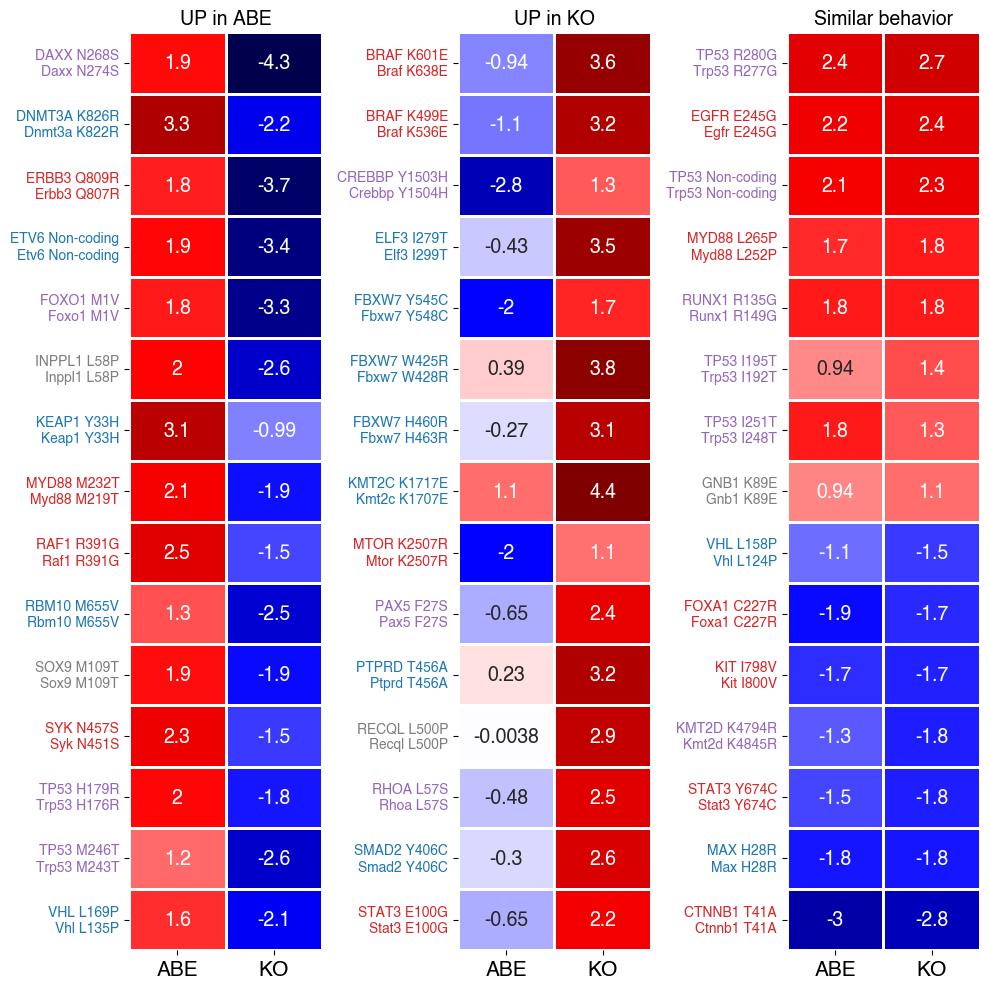

In [21]:
cc2_top = merged.sort_values(by=f'delta', ascending=False)
cc2_top = cc2_top[cc2_top['LFC_Spleen']>=1]


top = list(cc2_top[:15]['gRNA_id'])

cc2_bot = merged.sort_values(by=f'delta', ascending=True)
cc2_bot = cc2_bot[cc2_bot['LFC_KO']>=1]

bot =  list(cc2_bot[:15]['gRNA_id'])

#fig, ax = plt.subplots(2,1,figsize=(14,8))
subset = concated[concated['gRNA_id'].isin(top)]


top_T = merged[merged['gRNA_id'].isin(top)].sort_values(by=f'delta', ascending=False)[['LFC_Spleen', 'LFC_KO']] #['LFC_KO', 'LFC_spleen']


fig, ax = plt.subplots(1,3, figsize=(10,10))
#----number 1
g = sns.heatmap(top_T, cmap='seismic', linewidths=1, vmin=-4, vmax=4, annot=True, annot_kws={'size':14}, ax=ax[0], cbar=False)

name = []
hum_gene = []
for i, val in subset[subset['Type']=='BE'].iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']
    hum_gene.append(a)

    if type(b) != str:
        b = 'Non-coding'

    n = f'{a} {b}\n{c} {d}'
    name.append(n)

ax[0].set_yticklabels(name, rotation=0)
ax[0].set_xticklabels(['ABE', 'KO'], fontsize=15)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
#t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_yticklabels()):
    aa = merged.loc[merged['gene_name_h']==hum_gene[idx], 'Role in Cancer'].values[0]
    tick_label.set_color(color_dict[aa])


top_T = merged[merged['gRNA_id'].isin(top)][['LFC_Spleen', 'LFC_KO']] #['LFC_KO', 'LFC_spleen']


#-------number 2

top_T = merged[merged['gRNA_id'].isin(bot)].sort_values(by=f'delta', ascending=True)[['LFC_Spleen', 'LFC_KO']] #['LFC_KO', 'LFC_spleen']

h = sns.heatmap(top_T, cmap='seismic', linewidths=1, vmin=-4, vmax=4, annot=True, annot_kws={'size':14}, ax=ax[1], cbar=False)

subset = concated[concated['gRNA_id'].isin(bot)]


name = []
hum_gene = []
for i, val in subset[subset['Type']=='BE'].iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']
    hum_gene.append(a)

    if type(b) != str:
        b = 'Non-coding'

    n = f'{a} {b}\n{c} {d}'
    name.append(n)

ax[1].set_yticklabels(name, rotation=0)
ax[1].set_xticklabels(['ABE', 'KO'], fontsize=15)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
#t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(h.axes.get_yticklabels()):
    aa = merged.loc[merged['gene_name_h']==hum_gene[idx], 'Role in Cancer'].values[0]
    tick_label.set_color(color_dict[aa])



#------number 3
t1 = merged[(merged['delta']>-.5) & (merged['delta']<.5)].sort_values(by='LFC_KO', ascending=False)[:8]
t2 = merged[(merged['delta']>-.5) & (merged['delta']<.5)].sort_values(by='LFC_KO', ascending=False)[-7:]
similars = pd.concat((t1, t2))

similars2 = similars[['LFC_Spleen', 'LFC_KO']]

f = sns.heatmap(similars2, cmap='seismic', linewidths=1, vmin=-4, vmax=4, annot=True, annot_kws={'size':14}, ax=ax[2], cbar=False)

name = []
hum_gene = []
for i, val in similars.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']
    hum_gene.append(a)

    if type(b) != str:
        b = 'Non-coding'

    n = f'{a} {b}\n{c} {d}'
    name.append(n)

ax[2].set_yticklabels(name, rotation=0)
ax[2].set_xticklabels(['ABE', 'KO'], fontsize=15)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
#t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(f.axes.get_yticklabels()):
    aa = merged.loc[merged['gene_name_h']==hum_gene[idx], 'Role in Cancer'].values[0]
    tick_label.set_color(color_dict[aa])

ax[0].set_title('UP in ABE', fontsize=14)
ax[1].set_title('UP in KO', fontsize=14)
ax[2].set_title('Similar behavior', fontsize=14)


fig.tight_layout()
#fig.savefig('figures/figure4_heatmap_cbarv2.pdf')